# 4.4- Exercício - Desafio
Para finalizar a seção do **BERT** do nosso curso fica o exercício desafio que será divido em três partes:


1.   Utilizar o *dataset *`hate-speech-portuguese/hate_speech_portuguese` e dividi-lo em 3 partes `train`, `test` e `val`
2.   Usar o *dataset* dividido e avaliar somente a parte do `val`, rodar a predição no modelo `adalbertojunior/distilbert-portuguese-cased` e avaliar a métrica **F1 Score** que deve ser calculada usando o `evaluate` (https://huggingface.co/docs/evaluate/v0.1.2/en/package_reference/loading_methods) do Hugging Face.
3.  Realizar um *fine-tunning* para esse *dataset* e avaliar a métrica **F1 Score** comparando. Compare o resuldado desse modelo com o do passo anterior e veja qual ficou melhor.

**Importante:**

*   Todas as alterações devem ser registradas no Wandb para que seja possível realizar comparações entre os experimentos.

### Bibliotecas

In [1]:
%pip install transformers
%pip install datasets
%pip install torch
%pip install evaluate
%pip install wandb

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import load_dataset, DatasetDict
import evaluate
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.3 MB/s eta 0:00:00


## Constants

In [24]:
MODEL_ID="adalbertojunior/distilbert-portuguese-cased"
DATASET_ID="hate-speech-portuguese/hate_speech_portuguese"
PRETRAINED_PATH="./sentiment-analysis-bert-portuguese"
WANDB_PROJECT="aula2_finetuning"
WANDB_NAME="desafio_finetuning"

# Training arguments
RESULTS_PATH="./results"
MAX_LENGTH=512
NUM_LABELS=3
BATCH_SIZE=28
EPOCHS=3
LEARNING_RATE=3e-5

### Start Wandb

In [3]:
wandb.login()
wandb.init(project=WANDB_PROJECT, name=WANDB_NAME)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vandcarlos (vandcarlos-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Carregando o Dataset

In [25]:
dataset = load_dataset(DATASET_ID, revision="refs/convert/parquet")

print(dataset)

# Splita o dataset de treino tirando 20% para test
ds_split_one = dataset["train"].train_test_split(test_size=0.2, seed=42)
ds_test = ds_split_one["test"]

# Splita o dataset de treino tirando 20% para val
ds_split_two = ds_split_one["train"].train_test_split(test_size=0.2, seed=42)
ds_train = ds_split_two["train"]
ds_val = ds_split_two["test"]

dataset = DatasetDict({
    "train": ds_train,
    "test": ds_test,
    "val": ds_val,
})

train_dataset = dataset['train']
test_dataset = dataset['test']
val_dataset = dataset['val']

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'hatespeech_G1', 'annotator_G1', 'hatespeech_G2', 'annotator_G2', 'hatespeech_G3', 'annotator_G3'],
        num_rows: 5670
    })
})
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'hatespeech_G1', 'annotator_G1', 'hatespeech_G2', 'annotator_G2', 'hatespeech_G3', 'annotator_G3'],
        num_rows: 3628
    })
    test: Dataset({
        features: ['text', 'label', 'hatespeech_G1', 'annotator_G1', 'hatespeech_G2', 'annotator_G2', 'hatespeech_G3', 'annotator_G3'],
        num_rows: 1134
    })
    val: Dataset({
        features: ['text', 'label', 'hatespeech_G1', 'annotator_G1', 'hatespeech_G2', 'annotator_G2', 'hatespeech_G3', 'annotator_G3'],
        num_rows: 908
    })
})


### Mostra informações do dataset

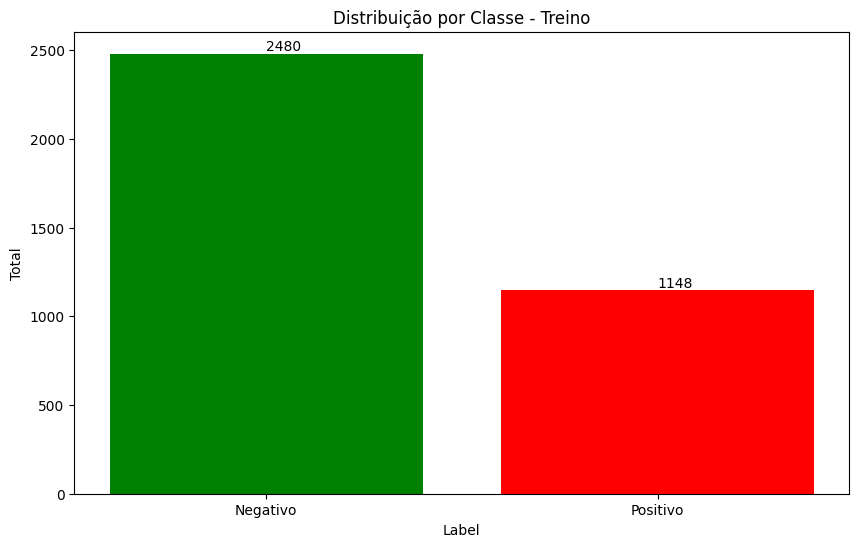

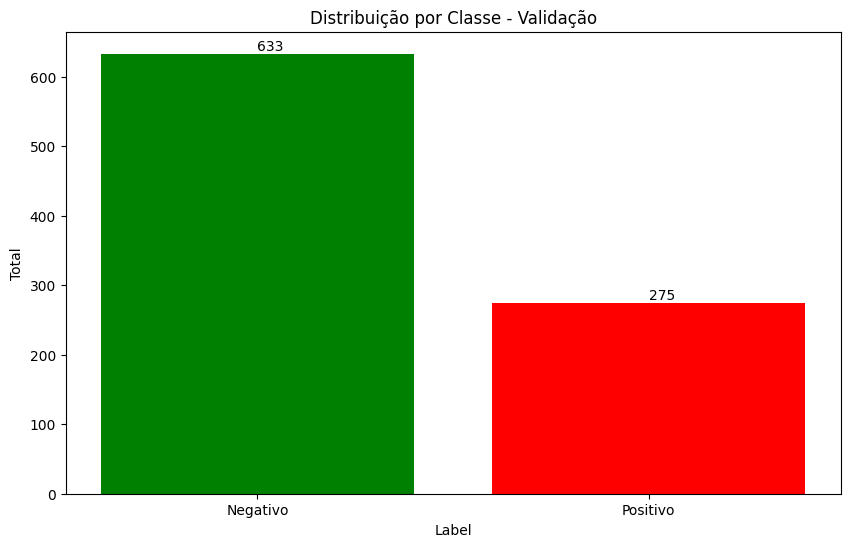

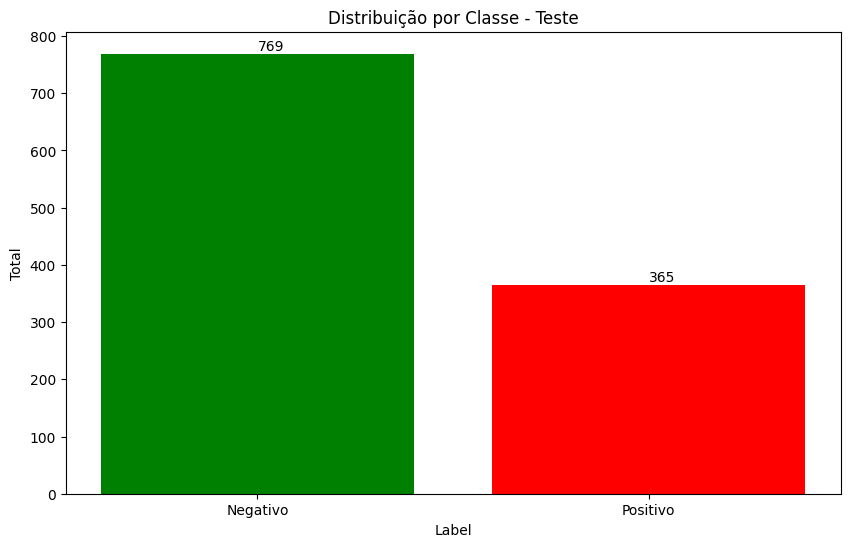

In [26]:
def show_info_dataset(dataset, title):
    df = dataset.to_pandas()

    label_counts = df['label'].value_counts()
    label_names = {0: 'Negativo', 1: 'Positivo', 2: 'Neutro'}
    labels = [label_names[label] for label in label_counts.index]

    colors = ['green', 'red', 'blue']

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, label_counts, color=colors)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')

    plt.title(title)
    plt.xlabel('Label')
    plt.ylabel('Total')
    plt.show()

show_info_dataset(train_dataset, 'Distribuição por Classe - Treino')
show_info_dataset(val_dataset, 'Distribuição por Classe - Validação')
show_info_dataset(test_dataset, 'Distribuição por Classe - Teste')

### Prepara o do DataSet

#### Tokenização

In [27]:
tokenizer = BertTokenizer.from_pretrained(MODEL_ID)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=MAX_LENGTH)

train_dataset = train_dataset.shuffle(seed=42)
test_dataset = test_dataset.shuffle(seed=42)
val_dataset = val_dataset.shuffle(seed=42)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/3628 [00:00<?, ? examples/s]

Map:   0%|          | 0/1134 [00:00<?, ? examples/s]

Map:   0%|          | 0/908 [00:00<?, ? examples/s]

#### Formatação

In [28]:
cols = ['input_ids', 'attention_mask', 'label']
train_dataset.set_format(type='torch', columns=cols)
test_dataset.set_format(type='torch', columns=cols)
val_dataset.set_format(type='torch', columns=cols)

### Carregando o modelo

In [29]:
model = BertForSequenceClassification.from_pretrained(MODEL_ID, num_labels=NUM_LABELS)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at adalbertojunior/distilbert-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Definição de métricas

In [30]:
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    f1_score = f1.compute(predictions=preds, references=labels, average="weighted")
    return {"f1": f1_score["f1"]}

### Monta o trainer

In [32]:
training_args = TrainingArguments(
    output_dir=RESULTS_PATH,
    eval_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    metric_for_best_model="f1",
    report_to=["wandb"],
    run_name=f"run_training")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics)

### Avalia antes do fine tuning

In [33]:
# Avaliando o "val" por estar no enunciando, porém avaliando o "test" por segurança
eval_val_before  = trainer.evaluate(eval_dataset=val_dataset)
eval_test_before = trainer.evaluate(eval_dataset=test_dataset)

f1_val_before  = eval_val_before["eval_f1"]
f1_test_before = eval_test_before["eval_f1"]
print(f"F1s antes do fine tunning. val={f1_val_before} | test={f1_test_before}")

F1s antes do fine tunning. val=0.2690702527243218 | test=0.25266022571236396


### Executa o fine tuning

In [34]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,F1
1,No log,0.515246,0.006100,0.711702
2,No log,0.517469,0.006100,0.748347
3,No log,0.582790,0.006100,0.750316


TrainOutput(global_step=390, training_loss=0.4479438977363782, metrics={'train_runtime': 525.5056, 'train_samples_per_second': 20.711, 'train_steps_per_second': 0.742, 'total_flos': 1441800878985216.0, 'train_loss': 0.4479438977363782, 'epoch': 3.0})

### Avalia após do fine tuning

In [35]:
eval_val_after  = trainer.evaluate(eval_dataset=val_dataset)
eval_test_after = trainer.evaluate(eval_dataset=test_dataset)

f1_val_after  = eval_val_after["eval_f1"]
f1_test_after = eval_test_after["eval_f1"]
print(f"F1s depois do fine tunning. val={f1_val_after} | test={f1_test_after}")

F1s depois do fine tunning. val=0.750315743764882 | test=0.7679837983858545


### Score final

In [36]:
if f1_val_after > f1_val_before:
    print("✅ Fine-tuning melhorou o desempenho no conjunto de validação!")
else:
    print("⚠️ Fine-tuning não melhorou o desempenho no conjunto de validação.")

if f1_test_after > f1_test_before:
    print("✅ Fine-tuning melhorou o desempenho no conjunto de teste!")
else:
    print("⚠️ Fine-tuning não melhorou o desempenho no conjunto de teste.")

wandb.log({
    "f1_val_before": f1_val_before,
    "f1_val_after": f1_val_after,
    "f1_test_before": f1_test_before,
    "f1_test_after": f1_test_after
})

✅ Fine-tuning melhorou o desempenho no conjunto de validação!
✅ Fine-tuning melhorou o desempenho no conjunto de teste!


### Finaliza o wandb

In [37]:
wandb.finish()

eval/f1,▅▅▅▅▁▁▇████
eval/loss,██████▁▁▂▂▁
eval/model_preparation_time,████▁▁▁▁▁▁▁
eval/runtime,▆▅▇▇▁█▂▂▂▁█
eval/samples_per_second,▅█▃▃▃▁▁▁▂▄▂
eval/steps_per_second,▅█▃▃▃▁▂▂▂▄▂
f1_test_after,▁
f1_test_before,▁
f1_val_after,▁
f1_val_before,▁
+2,...
